In [1]:
import os
import pandas as pd
import numpy as np
import glob
import cv2

from itertools import groupby
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def prepare_image_final(image):
    if not is_back_and_white(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=50)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if gray.mean() > 150:
            gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=0)
    return gray

def is_back_and_white(image):
    a = np.array_equiv(image[:, :, 0], image[:, :, 1])
    b = np.array_equiv(image[:, :, 1], image[:, :, 2])
    return (a and b)

def boost_contrast(img):
    mini = img.min()
    maxi = img.max()
    return (img-mini)*(255/(maxi-mini))

def add_seuillage(img, level=100):
    img = (img-level)*(255/(255-(2*level)))
    img = np.clip(img, 0, 255)
    return img

In [3]:
from skimage.morphology import label

def img_to_rle(img):
    result = []
    X = img.flatten('F').tolist()
    current_index = 1
    for k, g in groupby(X):
        l = len(list(g))
        if k > 0.5:
            result.append(current_index)
            result.append(l)
        current_index += l
    return result

"""
From Kaggle but I prefer groupby vs loop
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
"""

def prob_to_rles(x, cutoff=0.5):
    # From Kaggle
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        #yield rle_encoding(lab_img == i)
        yield img_to_rle(lab_img == i)

# Model 1

First, let's prepare a submission dataset with threshold method.

In [9]:
img_list = []
rle_list = []
for img in glob.glob("images/test/*/images/*.png"):
    img_name = os.path.basename(img)[:-4]
    image = cv2.imread(img)
    gray = prepare_image_final(image)
    ret1,th1 = cv2.threshold(gray, 40, 1, cv2.THRESH_BINARY)
    for rle in prob_to_rles(th1):
#     rle = img_to_rle(th1)
        img_list.append(img_name)
        rle_list.append(rle)

KeyboardInterrupt: 

In [4]:
df = pd.DataFrame()
df['ImageId'] = img_list
df['EncodedPixels'] = pd.Series(rle_list).apply(lambda x: ' '.join(str(y) for y in x))
df.to_csv('sub-simple_model.csv', index=False)

NameError: name 'img_list' is not defined

# Model 2

In [4]:
from keras.models import load_model
import numpy as np
import pickle

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (

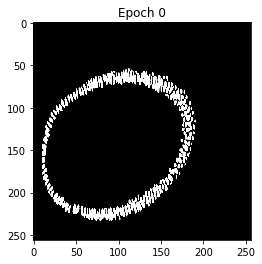

In [5]:
from models import model_extended as md

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

dimensions = np.array(load_obj("datas/dimensions"))
data = np.load('datas/dataset_multi_matrices_large.npz')
X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test, dim_train, dim_test = train_test_split(data["X1"], data["X2"], data["X3"], data["y"], dimensions, test_size=0.1, random_state=42)

h, w, c = X1_train.shape[1:]
BATCH_SIZE = 3
NB_IMAGES_TRAIN = X1_train.shape[0]
NB_IMAGES_TEST = X1_test.shape[0]
EPOCHS = 50
SEED = 42

model = md.create_model(h, w, c)
print(model.summary())
predictions = md.prediction_history(model, X1_test, X2_test, X3_test, y_test, "extended_large")  #  1D, 2D, light, resized, rgb, extended
train_generator, test_generator = md.create_generator(X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test, BATCH_SIZE=BATCH_SIZE, seed=SEED)

In [31]:
print(X3_train.shape)

(603, 256, 256, 3)


Epoch 1/50
201/201 [==============================] - 16s 77ms/step - loss: 0.0635 - binary_crossentropy: 0.0635 - val_loss: 0.0596 - val_binary_crossentropy: 0.0596
Epoch 2/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0671 - binary_crossentropy: 0.0671 - val_loss: 0.0541 - val_binary_crossentropy: 0.0541
Epoch 3/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0627 - binary_crossentropy: 0.0627 - val_loss: 0.0538 - val_binary_crossentropy: 0.0538
Epoch 4/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0667 - binary_crossentropy: 0.0667 - val_loss: 0.0485 - val_binary_crossentropy: 0.0485
Epoch 5/50
201/201 [==============================] - 16s 79ms/step - loss: 0.0640 - binary_crossentropy: 0.0640 - val_loss: 0.0583 - val_binary_crossentropy: 0.0583
Epoch 6/50
201/201 [==============================] - 16s 80ms/step - loss: 0.0601 - binary_crossentropy: 0.0601 - val_loss: 0.0520 - val_binary_crossentropy: 0.0520
Epoc

201/201 [==============================] - 19s 94ms/step - loss: 0.0560 - binary_crossentropy: 0.0560 - val_loss: 0.0480 - val_binary_crossentropy: 0.0480


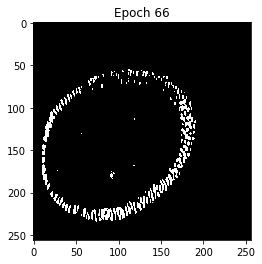

In [32]:
model.fit_generator(generator = train_generator,
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE,
                    callbacks = [predictions]
                    )

model.save("temp_fixed.h5")
model.save_weights('temp_weights_fixed.h5')

In [7]:
model.save("temp_fixed.h5")
model.save_weights('temp_weights_fixed.h5')

In [6]:
model.load_weights("temp_weights_fixed.h5")

In [18]:
img_list = []
rle_list = []

for img in glob.glob("images/test/*/images/*.png"):
    img_name = os.path.basename(img)[:-4]
    
    X3 = cv2.imread(img)  # X3
    X1 = prepare_image_final(X3)   #X1
    X2 = cv2.adaptiveThreshold(X1.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    W, H = X1.shape
    
    X1 = cv2.resize(X1, (256, 256))
    X2 = cv2.resize(X2, (256, 256))
    X3 = cv2.resize(X3, (256, 256))
    
    X1 = np.expand_dims(X1, 3)
    X2 = np.expand_dims(X2, 3)
    X1 = np.expand_dims(X1, 0).astype(np.float32)
    X2 = np.expand_dims(X2, 0).astype(np.float32)
    X3 = np.expand_dims(X3, 0).astype(np.float32)
    
    X1 /= 255.
    X2 /= 255.
    X3 /= 255.
    
    y = model.predict([X1, X2, X3])
    
    y = (y>0.9).astype(np.uint8)
    y = cv2.resize(y[0, :, :, 0], (H, W))
    
#     ret, thresh = cv2.threshold(y,0,1,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#     kernel = np.ones((2, 2), np.uint8)
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 1)
#     sure_bg = cv2.dilate(opening, kernel, iterations=1)
#     dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2, 5)
#     ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),1,0)
#     sure_fg = np.uint8(sure_fg)
#     unknown = cv2.subtract(sure_bg, sure_fg)
    
#     ret, markers = cv2.connectedComponents(sure_fg)
#     markers = markers+1
#     markers[unknown==255] = 0
#     markers = cv2.watershed(img,markers)
#     img[markers == -1] = [255,0,0]
    
#     plt.imshow(y, cmap="gray")
#     plt.title(img_name)
#     plt.show()
    
    for rle in prob_to_rles(y>0.9):
        img_list.append(img_name)
        rle_list.append(rle)

C:\Anaconda501\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
C:\Anaconda501\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (

In [28]:
filtered_img = []
filtered_rle = []
for img, rle in zip(img_list, rle_list):
    if len(rle) == 2 and rle[1] < 3:
        pass
    else:
        filtered_img.append(img)
        filtered_rle.append(rle)

In [30]:
df = pd.DataFrame()
df['ImageId'] = img_list
df['EncodedPixels'] = pd.Series(rle_list).apply(lambda x: ' '.join(str(y) for y in x))
df.to_csv('sub-cnn_model.csv', index=False)